In [4]:
importlib.reload(mfp)

<module 'MfpDataLib.functions' from '/home/emmett/Projects/Precision Nutrition Recommendation/IO-with-behavior-Change/MfpDataLib/functions.py'>

# Setup and Load Data

In [2]:
import MfpDataLib 
from MfpDataLib import functions as mfp
import importlib
import pandas as pd

In [3]:
# Load pre-processed data csv files
goals_df = pd.read_csv("data/myfitnesspal/processed/myfitnesspal_goals.csv")
meals_df = pd.read_csv("data/myfitnesspal/processed/myfitnesspal_meals.csv")

# Calculating user stats and plotting caloric goals

In [11]:
stats_df = pd.DataFrame(columns=['Person ID',
        'Start Date',
        'End Date',
        'Days Active',
        'Days active to span Ratio',
        'Days Logged',
        'Average Days Between Entry',
        'Median Days Between Entry',
        'Standard Deviation Days Betweeen Entry',
        'Longest Hiatus (Days)',
        'Average Meals Per Day',
        'Median Meals Per Day',
        'Standard Deviation Meals',
        'Average Calorie Goal',
        'Standard Deviation Calorie Goal',
        'Median Calorie Goal',
        'Average Calories Consumed per Day',
        'Standard Deviation Calories Consumed',
        'Median Calories Consumed per Day'])

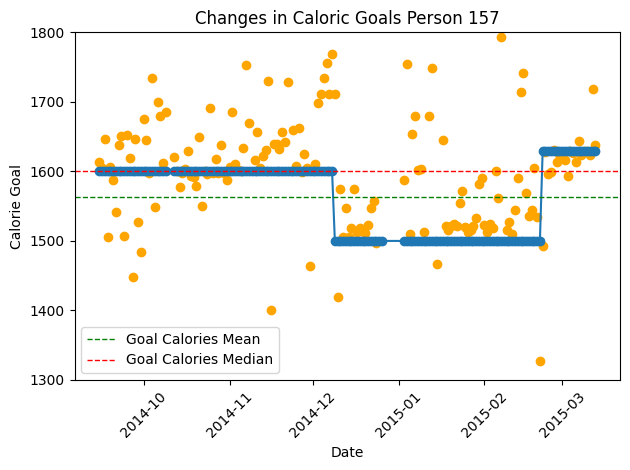

,Person ID,Start Date,End Date,Days Active,Days active to span Ratio,Days Logged,Average Days Between Entry,Median Days Between Entry,Standard Deviation Days Betweeen Entry,Longest Hiatus (Days),Average Meals Per Day,Median Meals Per Day,Standard Deviation Meals,Average Calorie Goal,Standard Deviation Calorie Goal,Median Calorie Goal,Average Calories Consumed per Day,Standard Deviation Calories Consumed,Median Calories Consumed per Day
0,157,2014-09-15,2015-03-13,171,0.95,180,1,1,0,8,5.549708,6.0,0.841314,1564,53,1600,1624,262,1604


In [12]:
stats_df = mfp.calc_user_stats(157, goals_df, meals_df, stats_df)
display(stats_df)

# IO Models & Plotting

In [6]:
userID = 4920
userGoals = goals_df[goals_df['user_id']==userID]
userMeals = pd.read_csv("data/temp/User4920_Foods_standardized.csv")
mfp.init_user(userID, userGoals, userMeals, print_stats=True)

171 daily entries with 107 total unique food items
